In [1]:
# Cheak gpu
!nvidia-smi

Sun Dec  3 11:12:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 529.04       Driver Version: 529.04       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   36C    P8     4W /  45W |    550MiB /  8188MiB |     28%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime

import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
# Check for GPU availability
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


In [4]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Load CSV file with image file names and labels
csv_path = 'train/train/train.csv'  # Replace with your actual CSV file path
data = pd.read_csv(csv_path)

# Path to the folder containing the images
image_folder = 'train/train/images'  # Replace with your actual image folder path

# Function to load and preprocess images
def load_and_preprocess_images(file_paths, target_size=(224, 224)):
    images = []
    for file_path in file_paths:
        image = cv2.imread(os.path.join(image_folder, file_path))
        image = cv2.resize(image, target_size)
        image = image.astype('float32') / 255.0  # Normalize pixel values
        images.append(image)
    return np.array(images)

# Load and preprocess images
images = load_and_preprocess_images(data['filename'])

# Encode labels (assuming labels are in 1, 2, 3, 4, 5, 6 format)
labels = data['label'] - 1  # Subtract 1 to convert to 0-based indices

# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# Print shapes for verification
print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)
print("Validation Images Shape:", val_images.shape)
print("Validation Labels Shape:", val_labels.shape)


Train Images Shape: (5760, 224, 224, 3)
Train Labels Shape: (5760,)
Validation Images Shape: (1440, 224, 224, 3)
Validation Labels Shape: (1440,)


In [5]:
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [6]:
# Set checkpoint path

checkpoint_path = "models/checkpoint.ckpt"

# Create a MOdelCheckpoint callback that saves the model's weights only
checkpoint_callbck = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        save_best_only=False,
                                                        save_freq="epoch",
                                                        verbose=1)

In [7]:

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()


In [10]:
model_5 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation="relu", input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2),
    

    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(64, activation="relu"),  # Added an extra dense layer
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation="softmax")
])

model_5.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [11]:
# Train the model
history_model_5 = model_5.fit(
    train_images, train_labels,
    epochs=10,
    validation_data=(val_images, val_labels),
    callbacks = [create_tensorboard_callback(dir_name = "models",
                                             experiment_name="model_5"),
                                             checkpoint_callbck])


Saving TensorBoard log files to: models/model_5/20231203-004449
Epoch 1/10
180/180 [==============================] - ETA: 0s - loss: 2.6463 - accuracy: 0.4172
Epoch 1: saving model to models\checkpoint.ckpt
180/180 [==============================] - 164s 903ms/step - loss: 2.6463 - accuracy: 0.4172 - val_loss: 1.6729 - val_accuracy: 0.3181
Epoch 2/10
180/180 [==============================] - ETA: 0s - loss: 1.0694 - accuracy: 0.5658
Epoch 2: saving model to models\checkpoint.ckpt
180/180 [==============================] - 120s 667ms/step - loss: 1.0694 - accuracy: 0.5658 - val_loss: 1.5792 - val_accuracy: 0.3944
Epoch 3/10
180/180 [==============================] - ETA: 0s - loss: 0.8190 - accuracy: 0.6736
Epoch 3: saving model to models\checkpoint.ckpt
180/180 [==============================] - 128s 709ms/step - loss: 0.8190 - accuracy: 0.6736 - val_loss: 1.0944 - val_accuracy: 0.6201
Epoch 4/10
180/180 [==============================] - ETA: 0s - loss: 0.6045 - accuracy: 0.7759
Epo

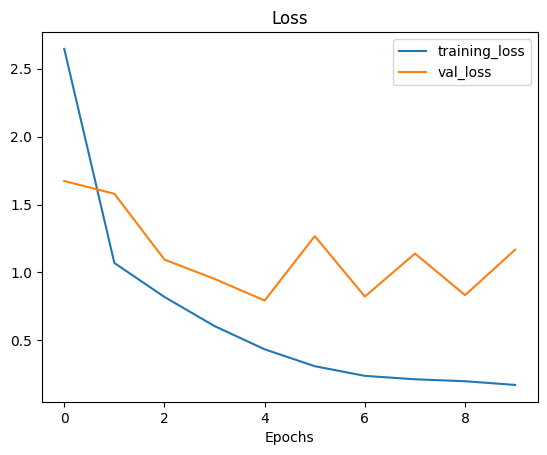

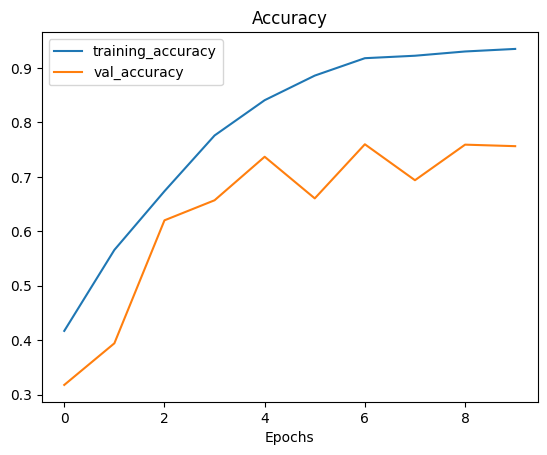

In [12]:
plot_loss_curves(history_model_5)

In [8]:
model_6 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation="relu", input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2),

    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(32, activation="relu"),  # Added an extra dense layer
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation="softmax")
])

model_6.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [9]:
# Train the model
history_model_6 = model_6.fit(
    train_images, train_labels,
    epochs=10,
    validation_data=(val_images, val_labels),
    callbacks = [create_tensorboard_callback(dir_name = "models",
                                             experiment_name="model_6"),
                                             checkpoint_callbck])


Saving TensorBoard log files to: models/model_6/20231203-032717
Epoch 1/10
180/180 [==============================] - ETA: 0s - loss: 1.6028 - accuracy: 0.3644
Epoch 1: saving model to models\checkpoint.ckpt
180/180 [==============================] - 124s 666ms/step - loss: 1.6028 - accuracy: 0.3644 - val_loss: 1.6514 - val_accuracy: 0.3285
Epoch 2/10
180/180 [==============================] - ETA: 0s - loss: 1.2624 - accuracy: 0.4714
Epoch 2: saving model to models\checkpoint.ckpt
180/180 [==============================] - 152s 845ms/step - loss: 1.2624 - accuracy: 0.4714 - val_loss: 1.4006 - val_accuracy: 0.4507
Epoch 3/10
180/180 [==============================] - ETA: 0s - loss: 1.1501 - accuracy: 0.5172
Epoch 3: saving model to models\checkpoint.ckpt
180/180 [==============================] - 194s 1s/step - loss: 1.1501 - accuracy: 0.5172 - val_loss: 1.2841 - val_accuracy: 0.5146
Epoch 4/10
180/180 [==============================] - ETA: 0s - loss: 1.0561 - accuracy: 0.5658
Epoch 

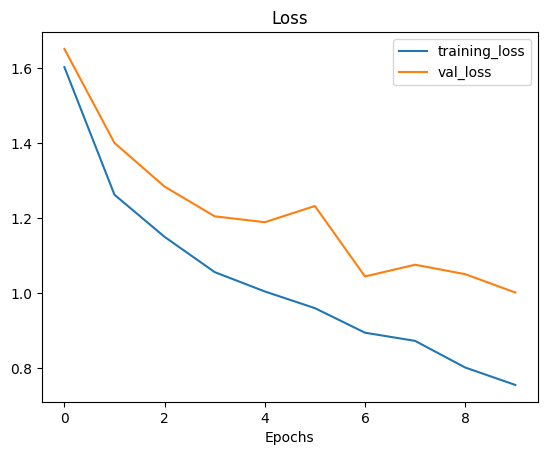

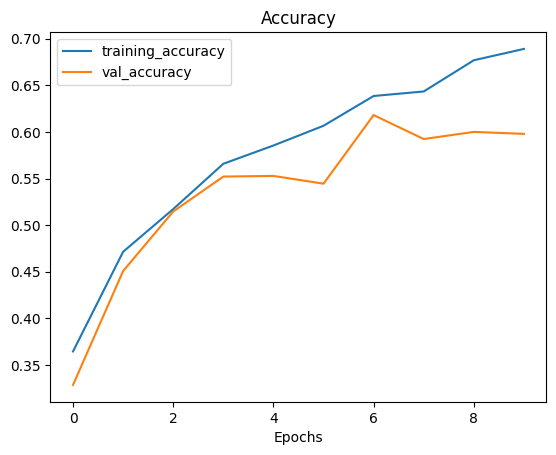

In [10]:
plot_loss_curves(history_model_6)

In [8]:
model_7 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation="relu", input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2),

    tf.keras.layers.Conv2D(128,3, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Conv2D(64,3, activation="relu"),
    tf.keras.layers.Conv2D(32,3, activation="relu"),  # Added an extra dense layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation="softmax")
])

model_7.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [9]:
# Train the model
history_model_7 = model_7.fit(
    train_images, train_labels,
    epochs=10,
    validation_data=(val_images, val_labels),
    callbacks = [create_tensorboard_callback(dir_name = "models",
                                             experiment_name="model_7"),
                                             checkpoint_callbck])


Saving TensorBoard log files to: models/model_7/20231203-050618
Epoch 1/10
180/180 [==============================] - ETA: 0s - loss: 1.5130 - accuracy: 0.3832
Epoch 1: saving model to models\checkpoint.ckpt
180/180 [==============================] - 131s 712ms/step - loss: 1.5130 - accuracy: 0.3832 - val_loss: 1.9364 - val_accuracy: 0.3285
Epoch 2/10
180/180 [==============================] - ETA: 0s - loss: 1.2386 - accuracy: 0.4882
Epoch 2: saving model to models\checkpoint.ckpt
180/180 [==============================] - 136s 756ms/step - loss: 1.2386 - accuracy: 0.4882 - val_loss: 1.8356 - val_accuracy: 0.3424
Epoch 3/10
180/180 [==============================] - ETA: 0s - loss: 1.0930 - accuracy: 0.5481
Epoch 3: saving model to models\checkpoint.ckpt
180/180 [==============================] - 178s 990ms/step - loss: 1.0930 - accuracy: 0.5481 - val_loss: 1.4168 - val_accuracy: 0.4208
Epoch 4/10
180/180 [==============================] - ETA: 0s - loss: 0.8871 - accuracy: 0.6396
Epo

In [11]:
model_7.save("best_model_7.keras")

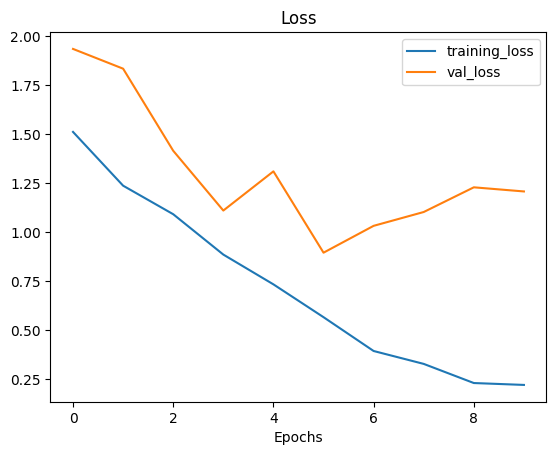

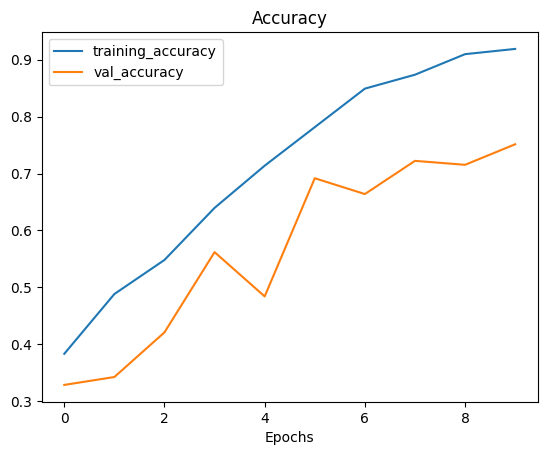

In [10]:
plot_loss_curves(history_model_7)

In [12]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Load the test data CSV file
test_csv_path = 'test/test/test.csv'  # Replace with the actual path
test_data = pd.read_csv(test_csv_path)

# Path to the folder containing test images
test_image_folder = 'test/test/images'  # Replace with the actual path

# Function to load and preprocess test images
def load_and_preprocess_test_images(file_paths, target_size=(224, 224)):
    images = []
    for file_path in file_paths:
        image = cv2.imread(os.path.join(test_image_folder, file_path))
        image = cv2.resize(image, target_size)
        image = image.astype('float32') / 255.0  # Normalize pixel values
        images.append(image)
    return np.array(images)

# Load and preprocess test images
test_images = load_and_preprocess_test_images(test_data['filename'])



# Enable memory debugging
tf.debugging.experimental.enable_dump_debug_info("memory_debug")

# Make predictions
predictions = model_7.predict(test_images)

# Disable memory debugging
tf.debugging.experimental.disable_dump_debug_info()


# Assign labels based on the predicted probabilities
predicted_labels = np.argmax(predictions, axis=1)

# Add predicted labels to the test data DataFrame
test_data['predicted_label'] = predicted_labels + 1  # Add 1 to convert back to 1-indexed labels

# Save the updated test data CSV file
test_data.to_csv('Results/result.csv', index=False)  # Replace with the desired path


INFO:tensorflow:Enabled dumping callback in thread MainThread (dump root: memory_debug, tensor debug mode: NO_TENSOR)
150/150 [==============================] - 20s 120ms/step
INFO:tensorflow:Disabled dumping callback in thread MainThread (dump root: memory_debug)


In [11]:
# Let's make create_model() function to model from a url
def create_model(model_url, num_classes=10):
  """
  Takes a tensorflow hub URL and creates a keras sequential model with it.

  Args:
    model_url(str): A tensorflow hub feature extraction URL.
    num_classes (int): Number of output nrurons in the output layer,
    should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layers = hub.KerasLayer(model_url,
                                            trainable=False, # Freeze the already learned pattarens
                                            name= "feature_extraction_layer",
                                            input_shape=(224,224,3)) # Freeze the already learned pattarens
  # cretae our own model
  model = tf.keras.Sequential([
      feature_extractor_layers,
      layers.Dense(num_classes, activation="softmax", name = "output_layer")
  ])

  return model


In [12]:
efficientnet_url= "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [13]:
efficientnet_model = create_model(model_url= efficientnet_url,
                                  num_classes=6)

In [16]:
# compile Efficientnet model
efficientnet_model.compile(loss="sparse_categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

In [17]:
# Train the model
history_model_8 = efficientnet_model.fit(
    train_images, train_labels,
    epochs=10,
    validation_data=(val_images, val_labels),
    callbacks = [create_tensorboard_callback(dir_name = "models",
                                             experiment_name="model_8"),
                                             checkpoint_callbck])


Saving TensorBoard log files to: models/model_8/20231203-112526
Epoch 1/10
180/180 [==============================] - ETA: 0s - loss: 0.8740 - accuracy: 0.6663
Epoch 1: saving model to models\checkpoint.ckpt
180/180 [==============================] - 129s 657ms/step - loss: 0.8740 - accuracy: 0.6663 - val_loss: 0.6849 - val_accuracy: 0.7417
Epoch 2/10
180/180 [==============================] - ETA: 0s - loss: 0.5968 - accuracy: 0.7701
Epoch 2: saving model to models\checkpoint.ckpt
180/180 [==============================] - 153s 849ms/step - loss: 0.5968 - accuracy: 0.7701 - val_loss: 0.6034 - val_accuracy: 0.7646
Epoch 3/10
180/180 [==============================] - ETA: 0s - loss: 0.5125 - accuracy: 0.8069
Epoch 3: saving model to models\checkpoint.ckpt
180/180 [==============================] - 112s 625ms/step - loss: 0.5125 - accuracy: 0.8069 - val_loss: 0.5628 - val_accuracy: 0.7833
Epoch 4/10
180/180 [==============================] - ETA: 0s - loss: 0.4562 - accuracy: 0.8297
Epo

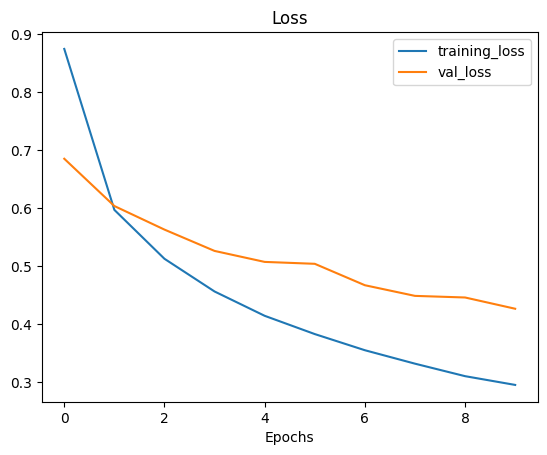

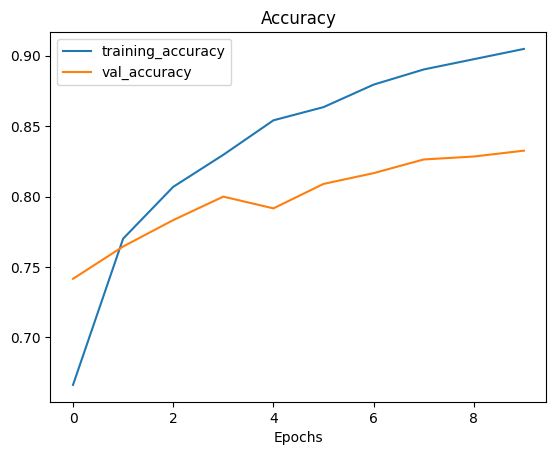

In [19]:
plot_loss_curves(history_model_8)

In [20]:
efficientnet_model.save("best_model_8.keras")


In [21]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Load the test data CSV file
test_csv_path = 'test/test/test.csv'  # Replace with the actual path
test_data = pd.read_csv(test_csv_path)

# Path to the folder containing test images
test_image_folder = 'test/test/images'  # Replace with the actual path

# Function to load and preprocess test images
def load_and_preprocess_test_images(file_paths, target_size=(224, 224)):
    images = []
    for file_path in file_paths:
        image = cv2.imread(os.path.join(test_image_folder, file_path))
        image = cv2.resize(image, target_size)
        image = image.astype('float32') / 255.0  # Normalize pixel values
        images.append(image)
    return np.array(images)

# Load and preprocess test images
test_images = load_and_preprocess_test_images(test_data['filename'])



# Enable memory debugging
tf.debugging.experimental.enable_dump_debug_info("memory_debug")

# Make predictions
predictions = efficientnet_model.predict(test_images)

# Disable memory debugging
tf.debugging.experimental.disable_dump_debug_info()


# Assign labels based on the predicted probabilities
predicted_labels = np.argmax(predictions, axis=1)

# Add predicted labels to the test data DataFrame
test_data['predicted_label'] = predicted_labels + 1  # Add 1 to convert back to 1-indexed labels

# Save the updated test data CSV file
test_data.to_csv('Results/result.csv', index=False)  # Replace with the desired path


INFO:tensorflow:Enabled dumping callback in thread MainThread (dump root: memory_debug, tensor debug mode: NO_TENSOR)


INFO:tensorflow:Enabled dumping callback in thread MainThread (dump root: memory_debug, tensor debug mode: NO_TENSOR)


150/150 [==============================] - 81s 517ms/step
INFO:tensorflow:Disabled dumping callback in thread MainThread (dump root: memory_debug)


INFO:tensorflow:Disabled dumping callback in thread MainThread (dump root: memory_debug)
